In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 250
plt.rc("font", size=14)
sns.set(style="white") 
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.simplefilter(action='ignore')

### Loading the dataset

In [2]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("https://raw.githubusercontent.com/SayaliD6/Datasets_used_in_assignments/main/XGBM_LGBM_data/Titanic_train_lg_xg.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/SayaliD6/Datasets_used_in_assignments/main/XGBM_LGBM_data/Titanic_test_lg_xg.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.shape

(891, 12)

In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_df.shape

(418, 11)

In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
for i in train_df.isna().sum():
    print((i/len(train_df))*100)

0.0
0.0
0.0
0.0
0.0
19.865319865319865
0.0
0.0
0.0
0.0
77.10437710437711
0.22446689113355783


#### Rule for missing value imputation:
#### If NA values are between 1 to 5%, drop na (rows)
#### If NA value are 5 to 40%, fillna(replace)
#### If NA values are greater than 50% in a column, drop that entire column.

S    644
C    168
Q     77
Name: Embarked, dtype: int64


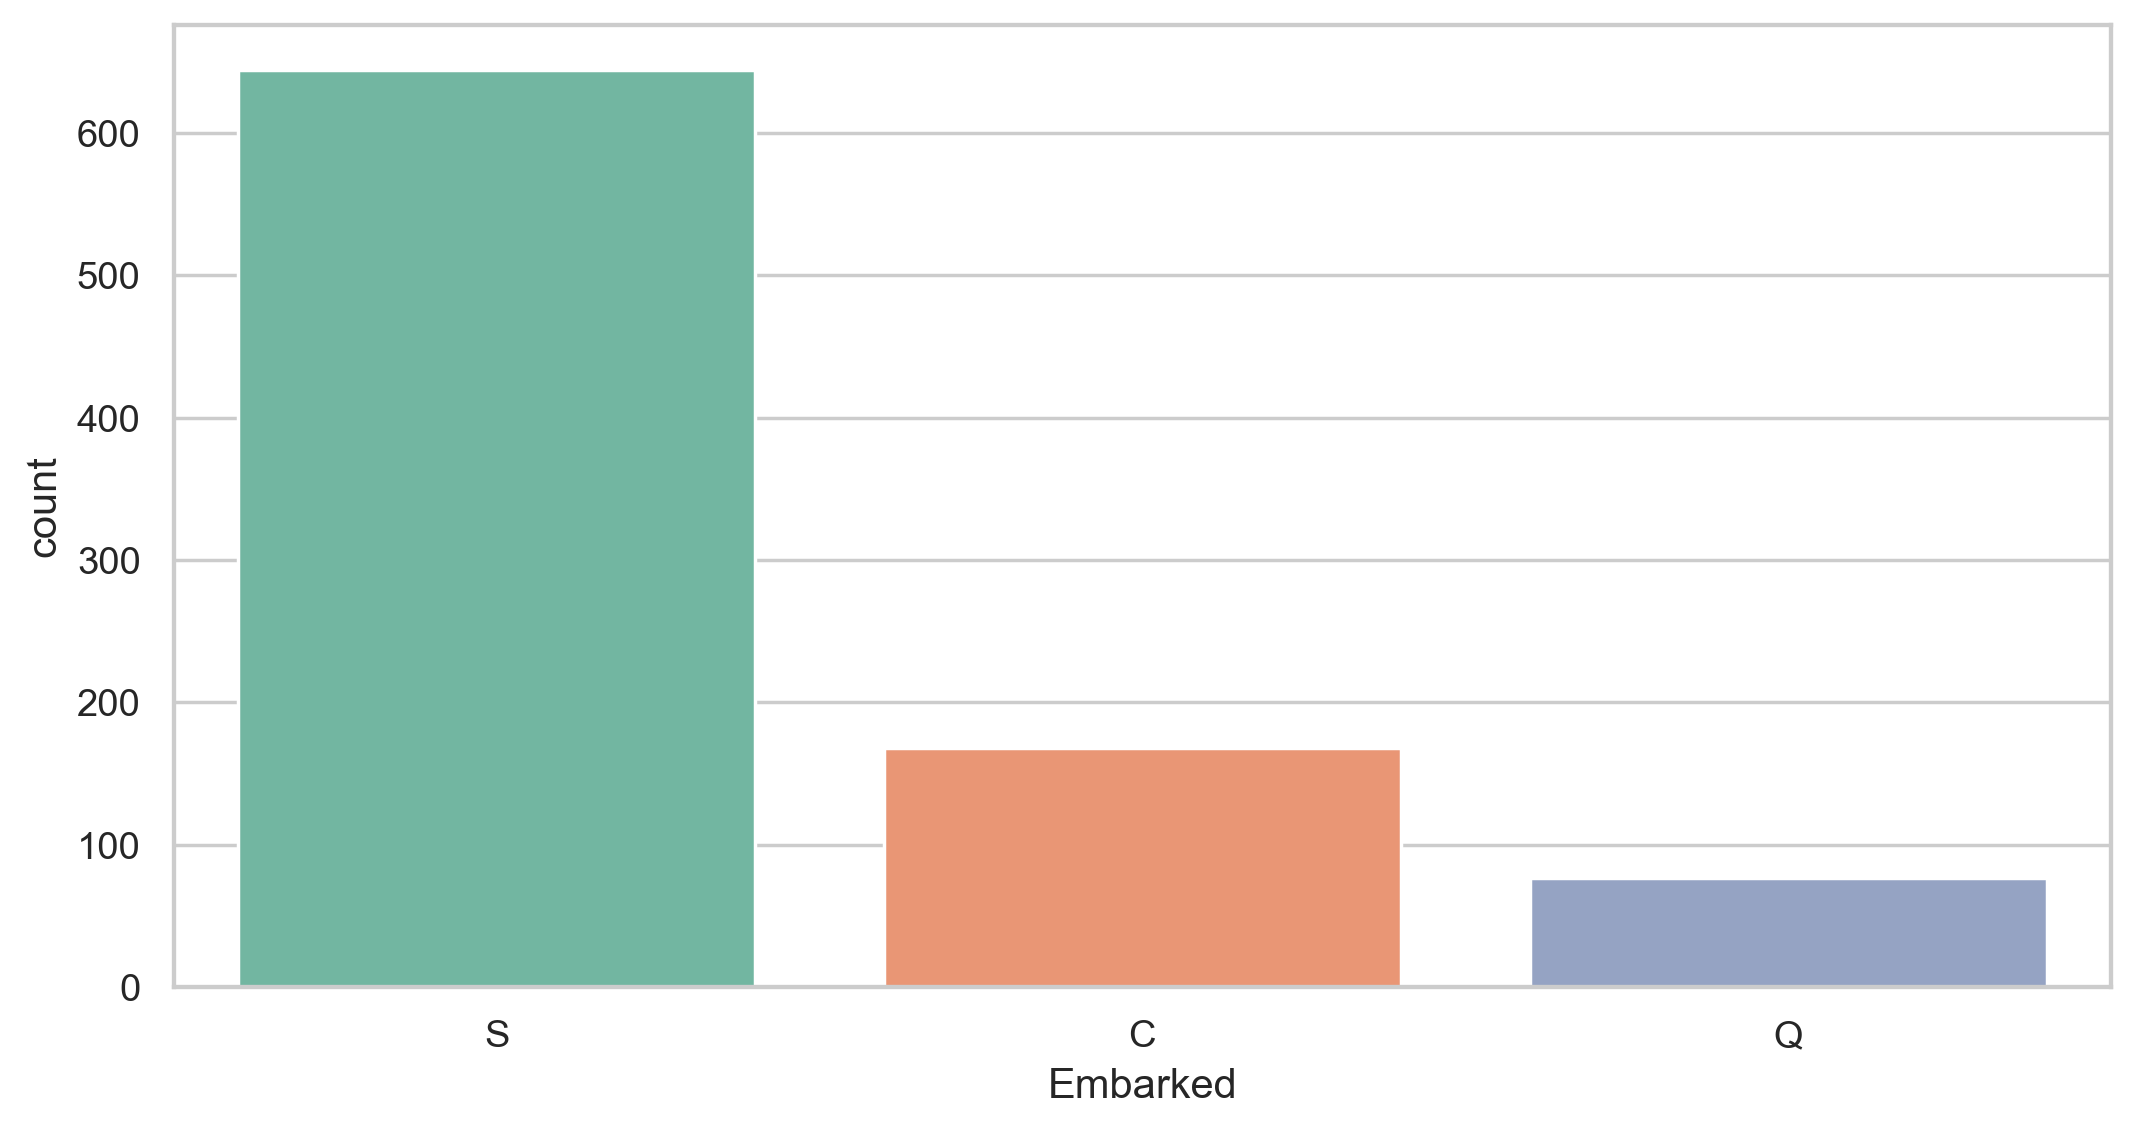

In [9]:
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

#### The most passengers boarded in Southhampton, so we'll impute those 2 NaN's w/ "S"

In [10]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [11]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [12]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### both SibSp and Parch relate to traveling with family. For simplicity's sake (and to account for possible multicollinearity), we will combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [13]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [14]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


In [15]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [16]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [17]:
test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

In [18]:
test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

In [19]:
testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


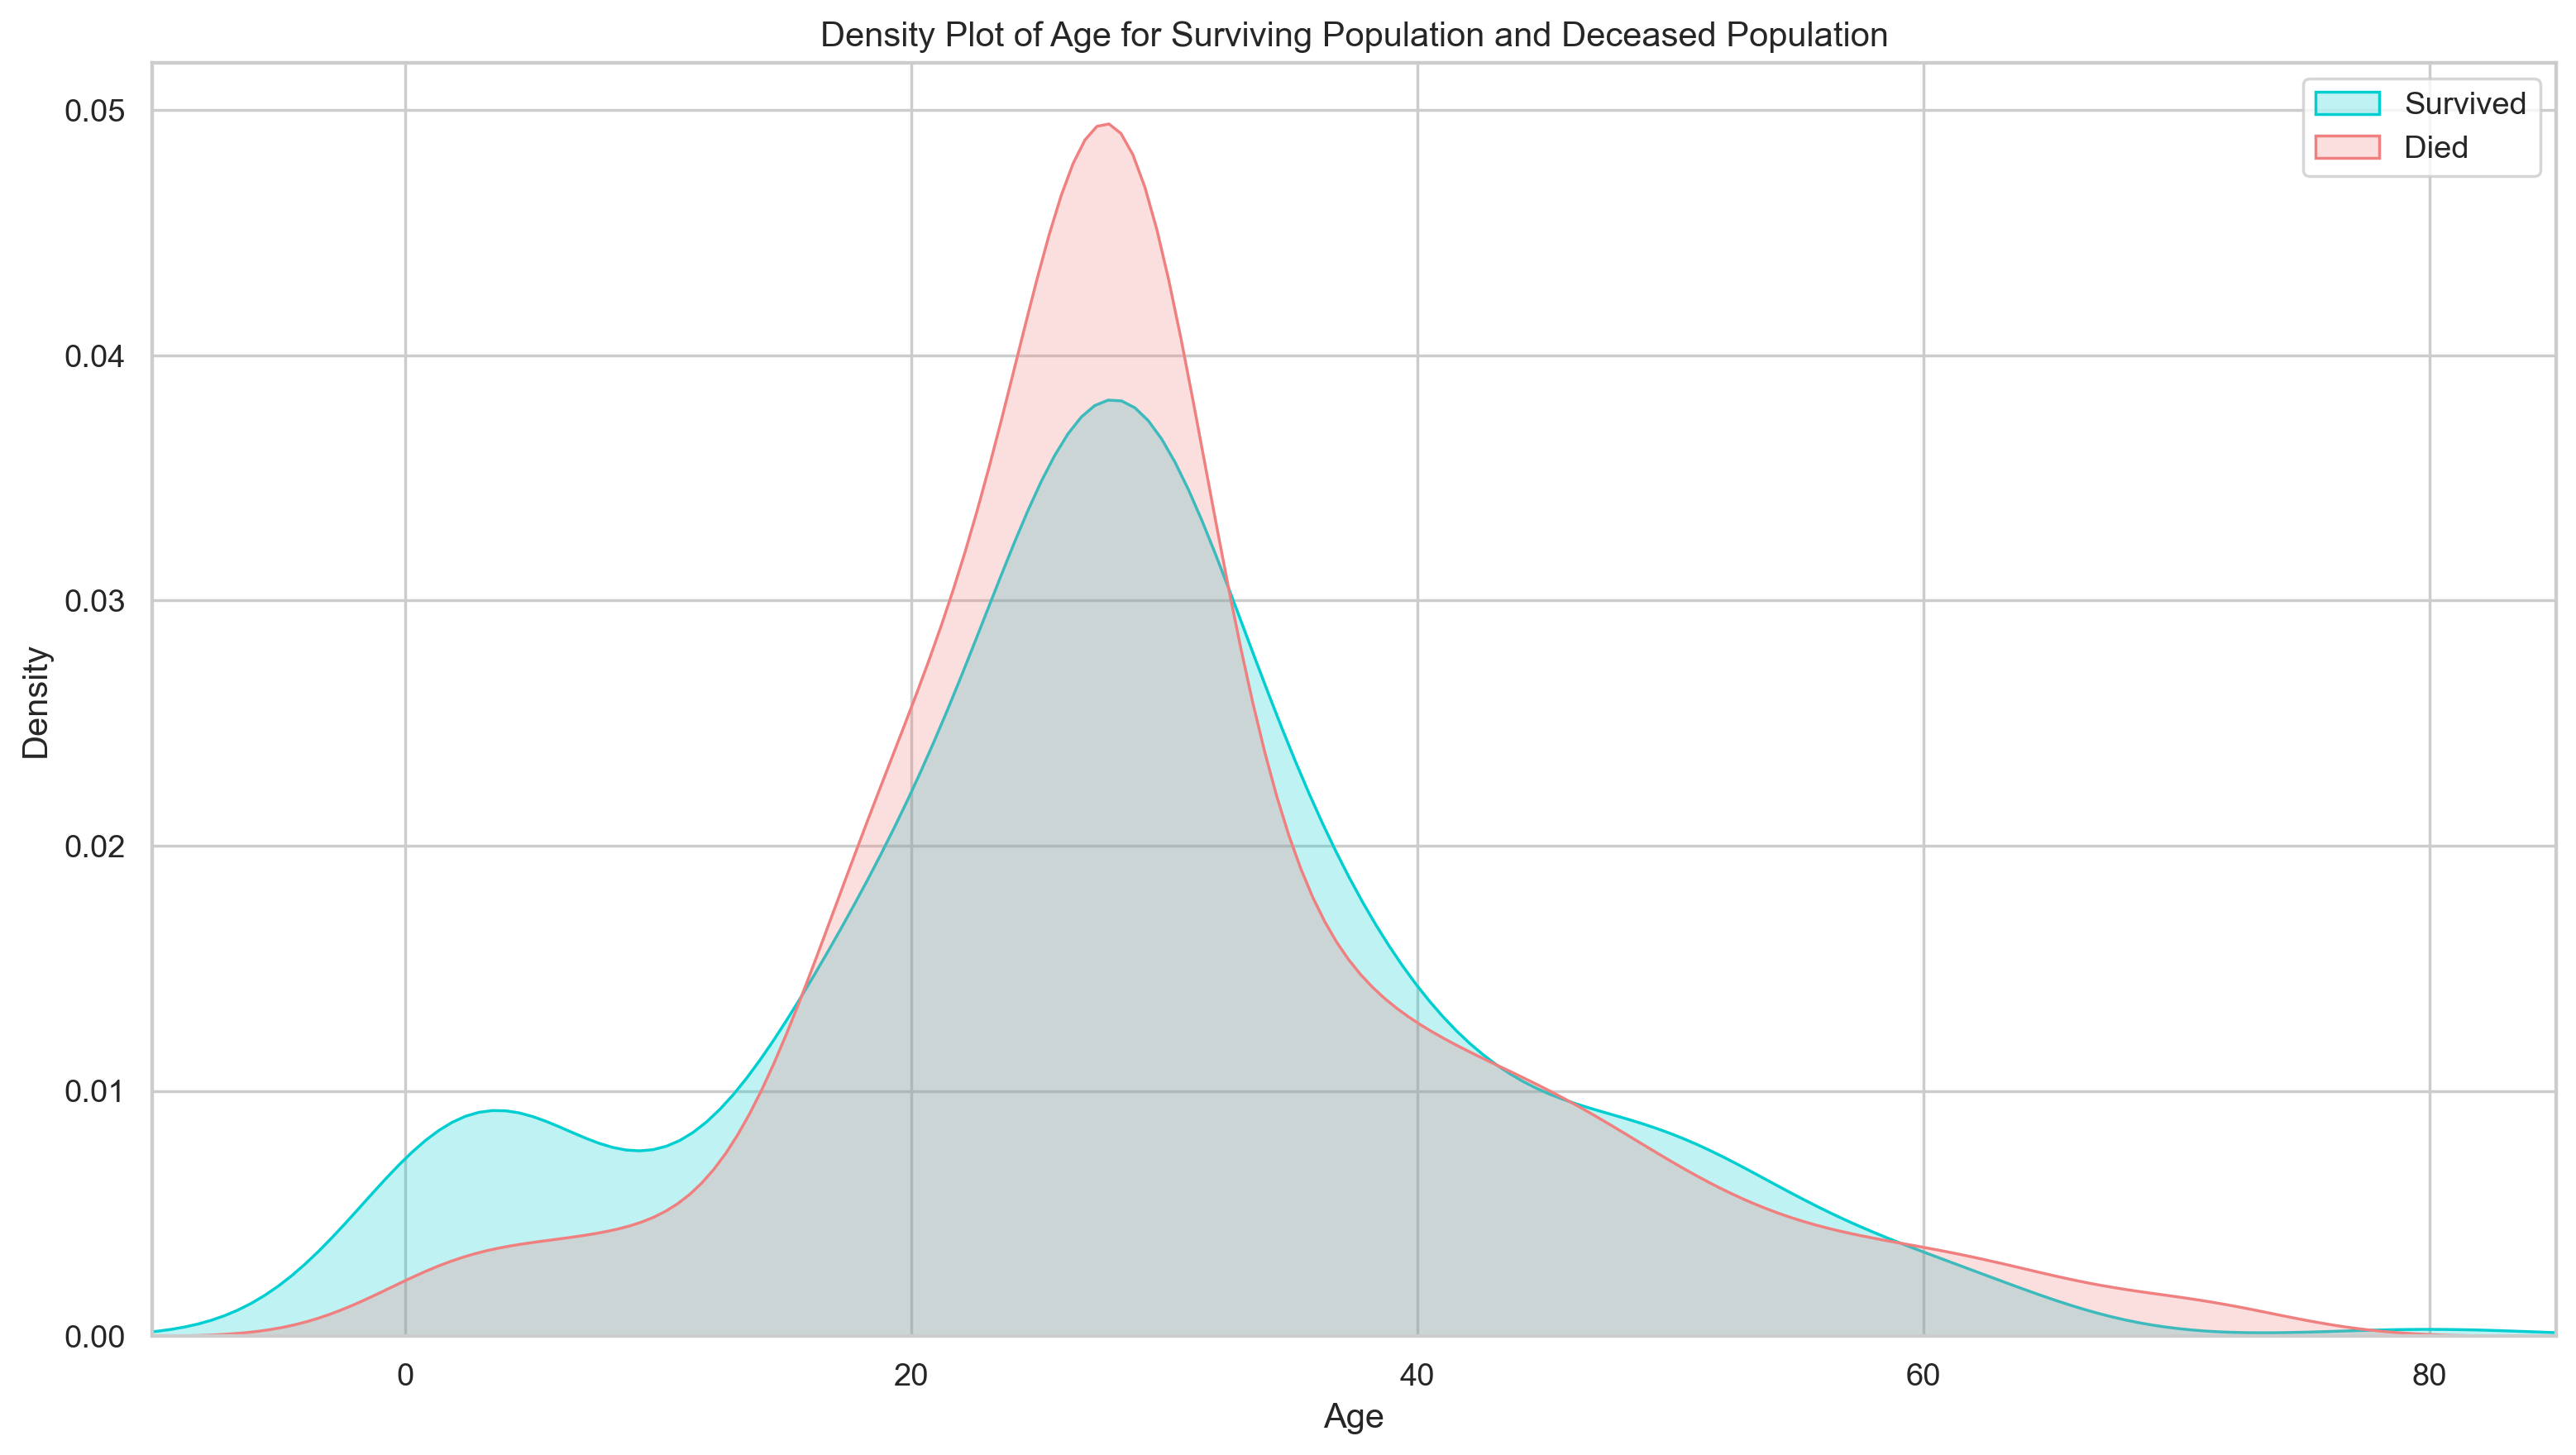

In [20]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

#### The age distribution for survivors and deceased is actually very similar. One notable difference is that, of the survivors, a larger proportion were children. The passengers evidently made an attempt to save children by giving them a place on the life rafts.

### Considering the survival rate of passengers under 16, I'll also include another categorical variable in my dataset: "Minor

In [21]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

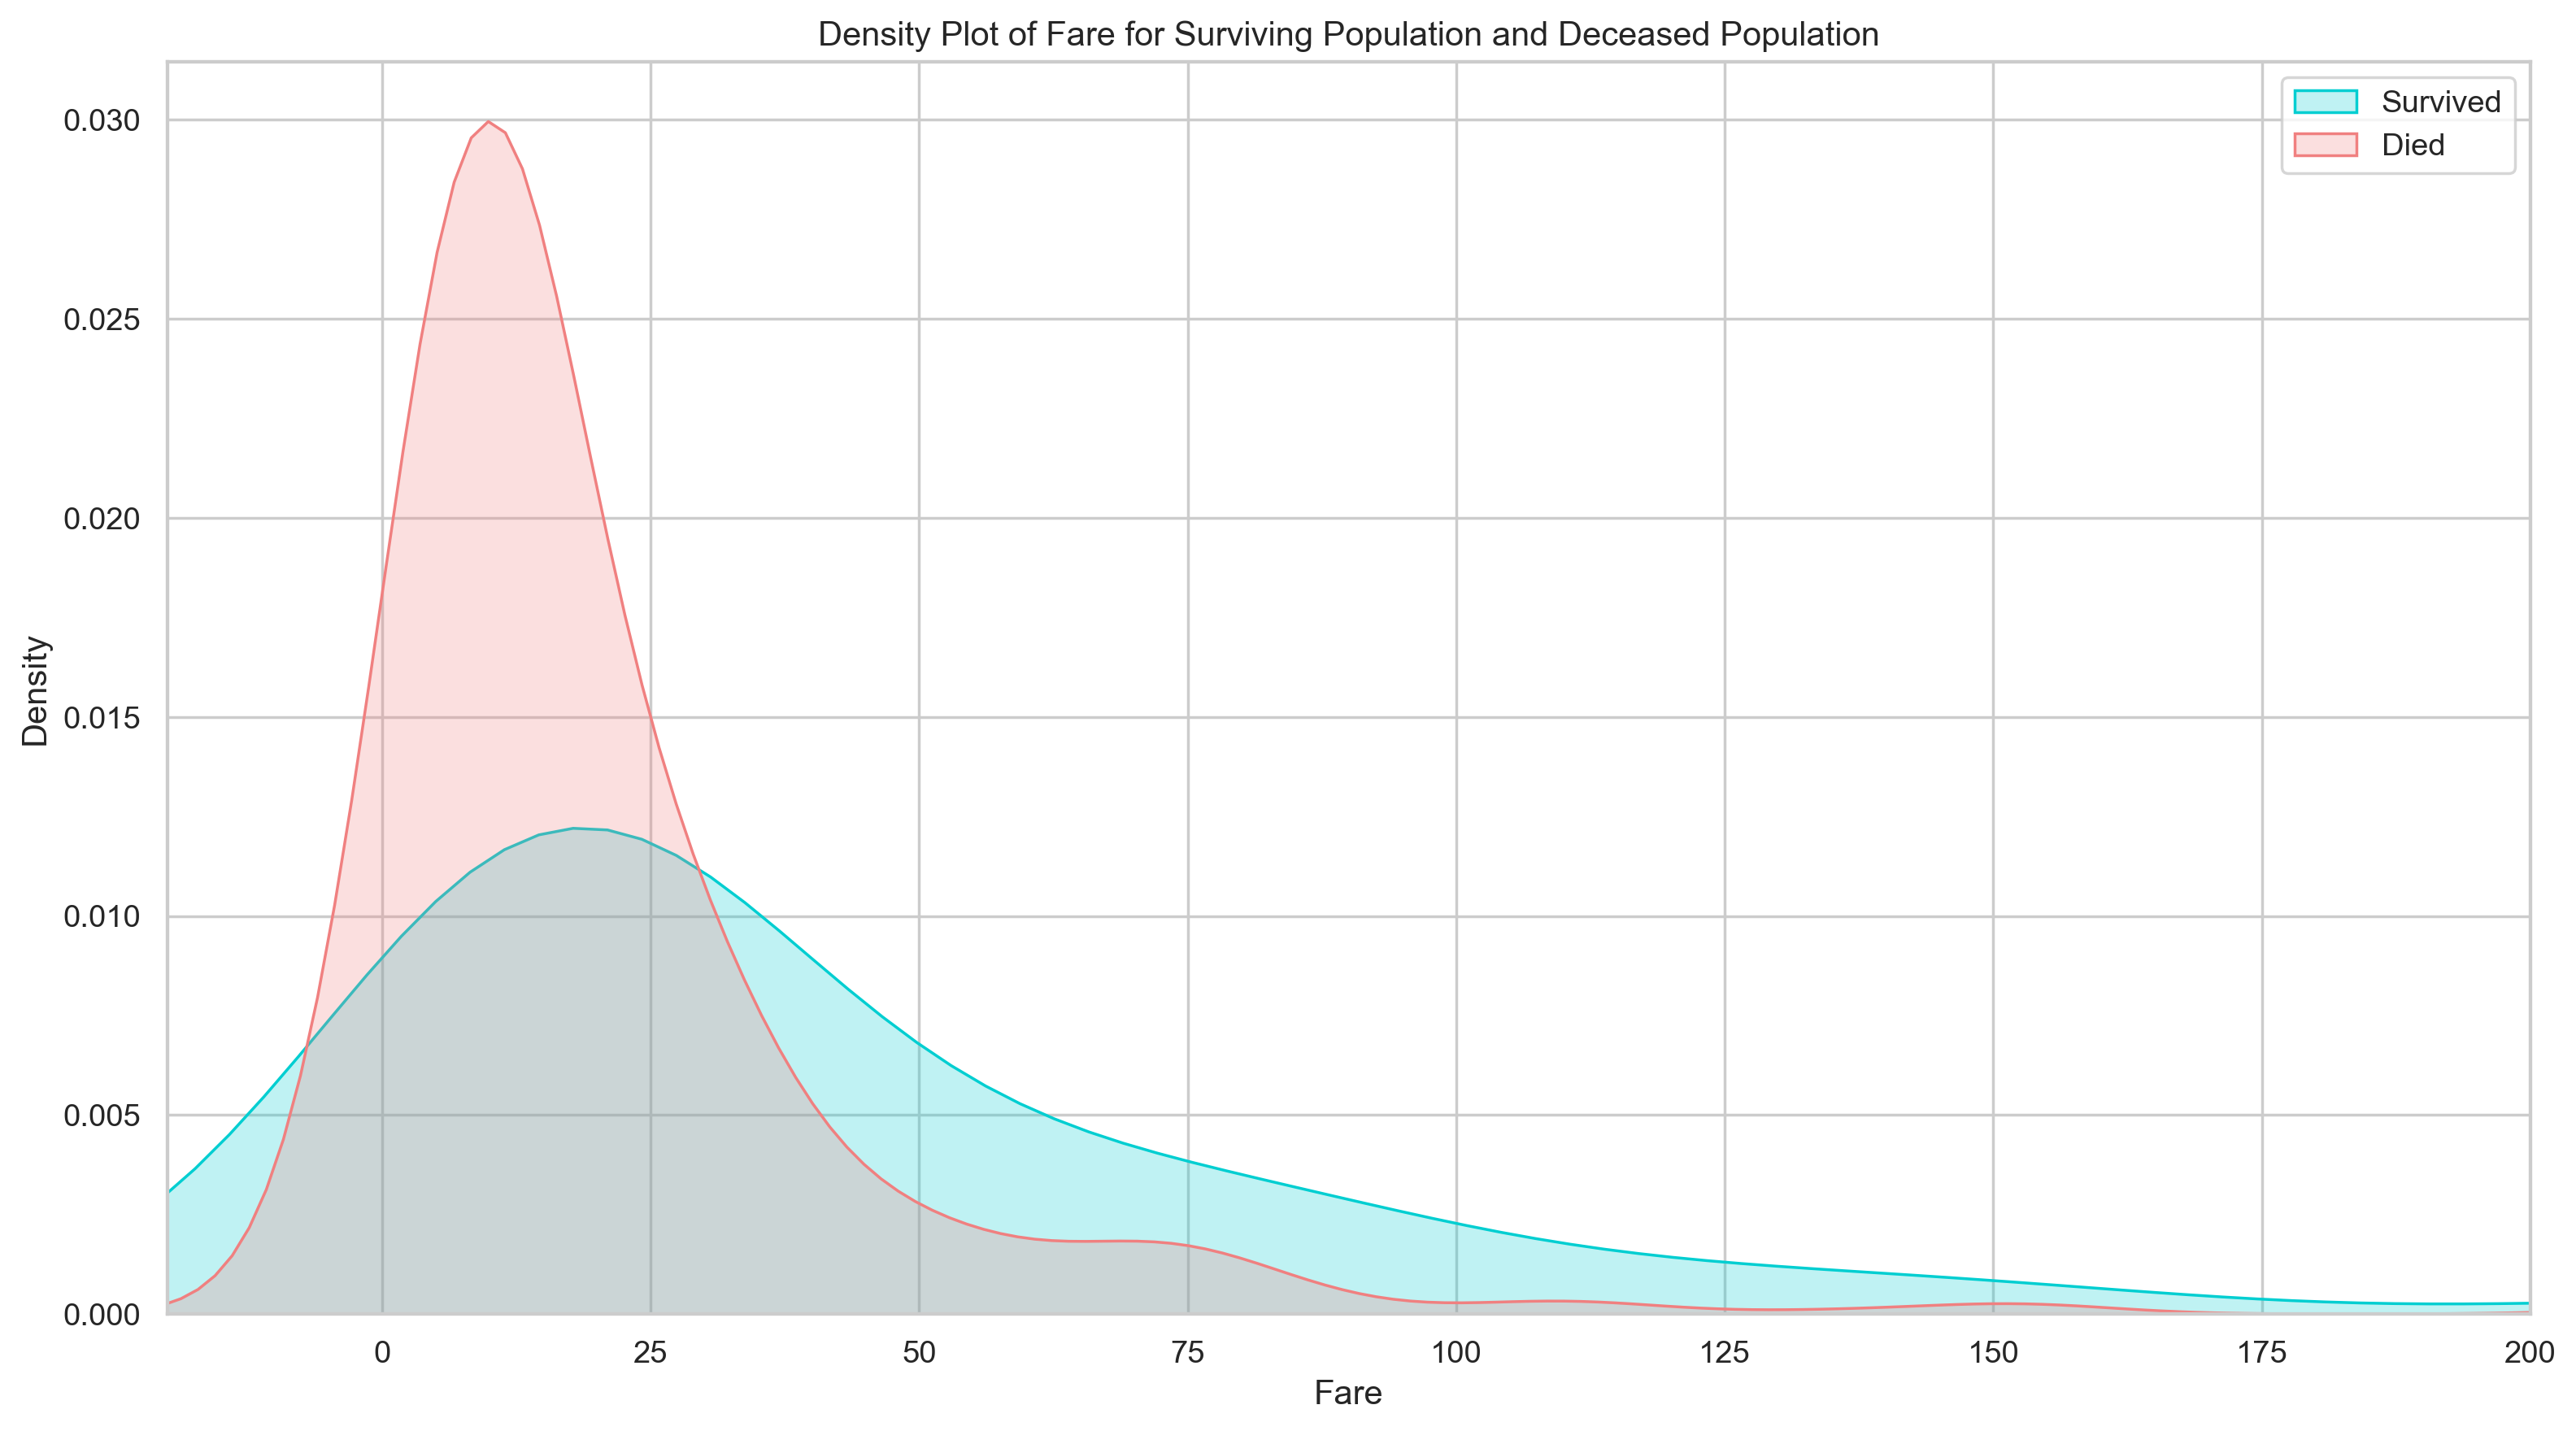

In [22]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

#### As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model. Passengers who paid lower fare appear to have been less likely to survive. This is probably strongly correlated with Passenger Class, which we'll look at next.

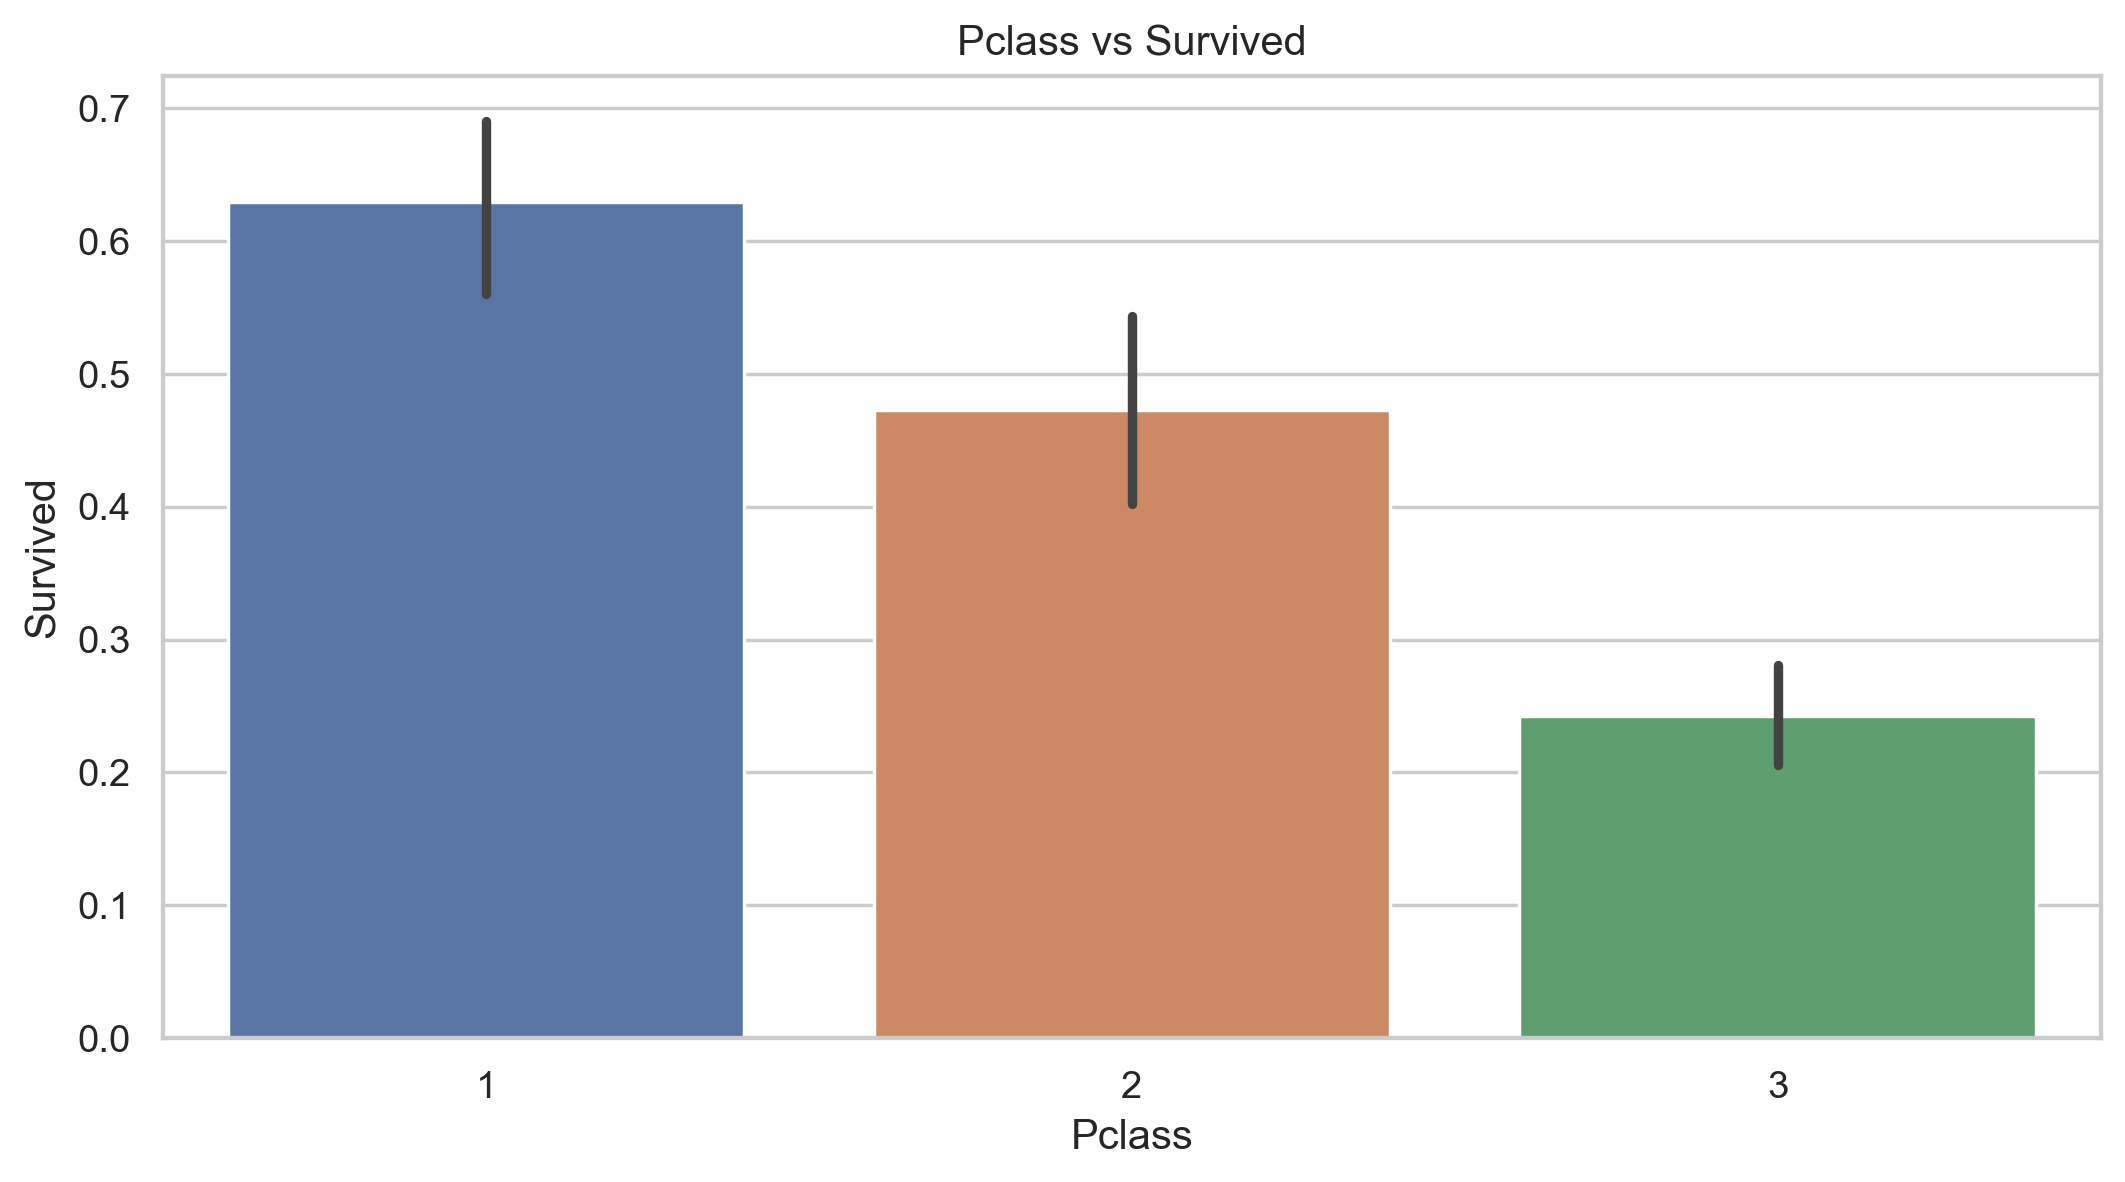

In [23]:
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.xlabel('Pclass')
plt.ylabel('Survived')
plt.title('Pclass vs Survived')
plt.show()

#### Unsurprisingly, being a first class passenger was safest.

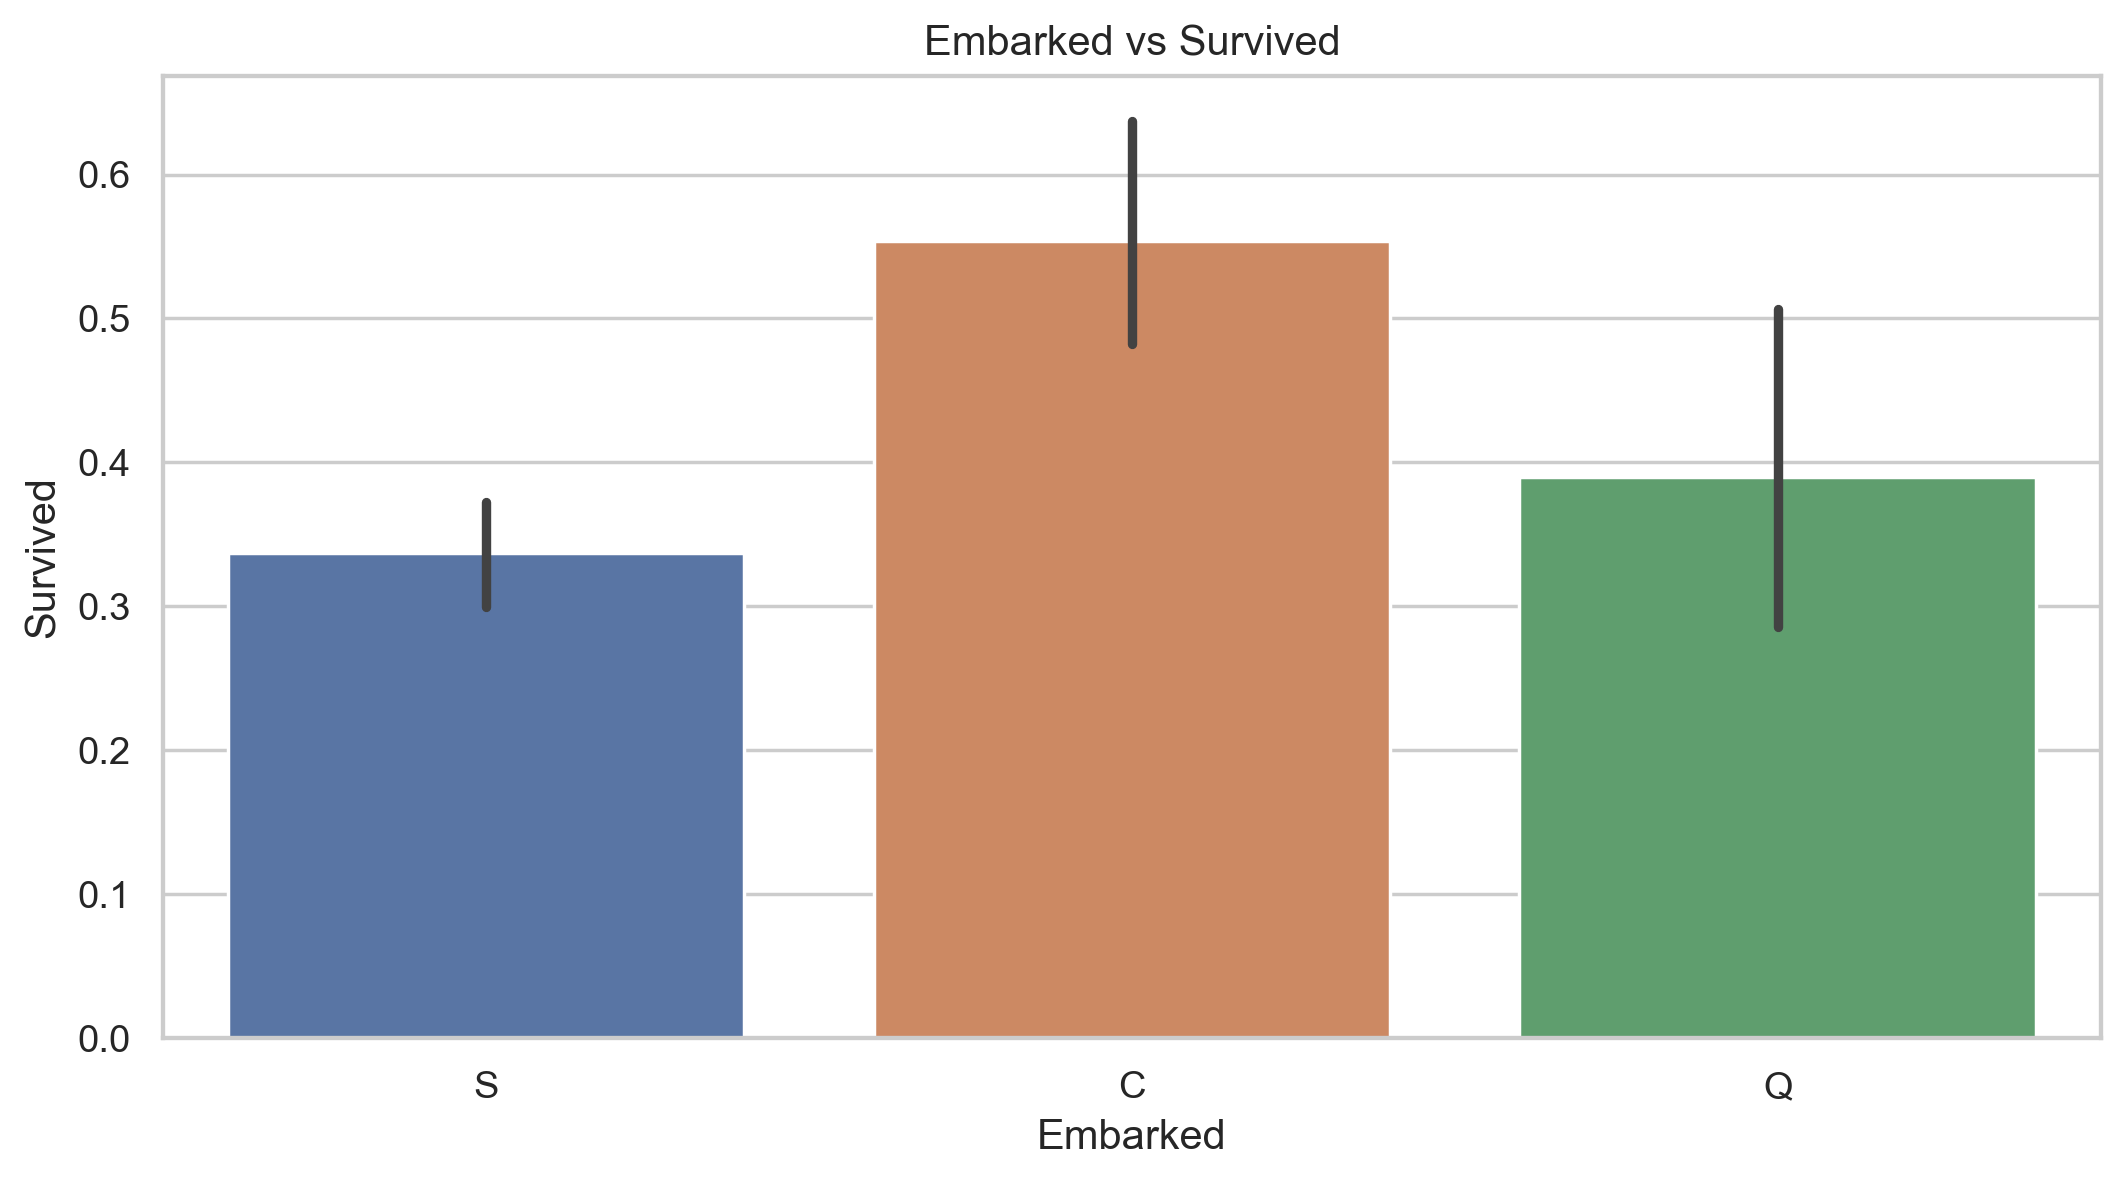

In [24]:
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.xlabel('Embarked')
plt.ylabel('Survived')
plt.title('Embarked vs Survived')
plt.show()

#### Cherbourg passengers had the highest survival rate. Southampton passengers had a slightly lower rate than those from Queenstown. The larger number of Southampton passengers gives more confidence in its survival rate. The range for Queenstown overlaps with Southampton, so Queenstown passengers might have had similar or lower survival rates.

#### Individuals traveling without family were more likely to die in the disaster than those with family aboard. Given the era, it's likely that individuals traveling alone were likely male.

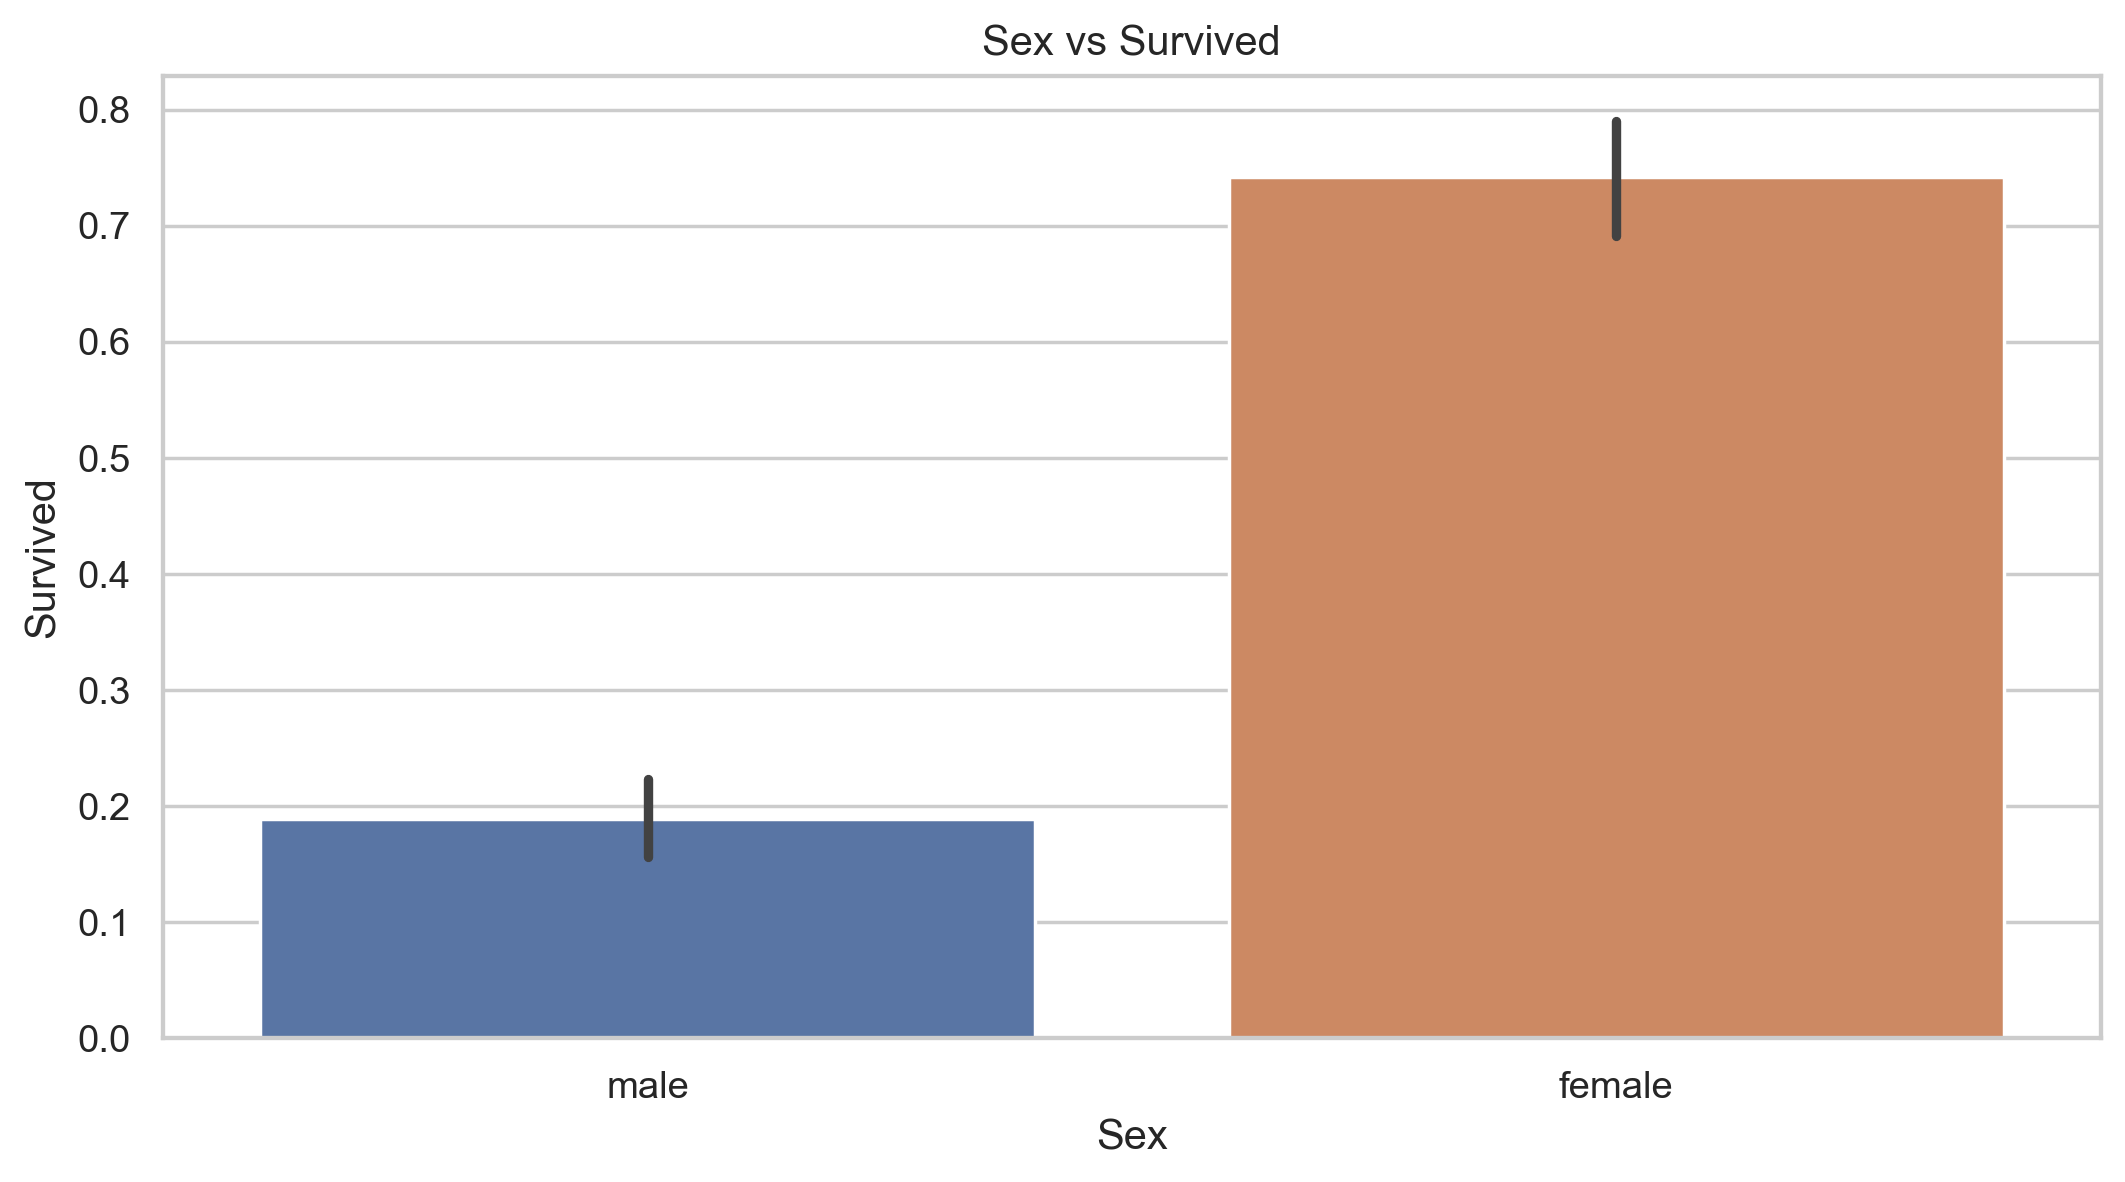

In [25]:
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.xlabel('Sex')
plt.ylabel('Survived')
plt.title('Sex vs Survived')
plt.show()

#### This is a very obvious difference. Clearly being female greatly increased your chances of survival.

In [26]:
# Prepare features and target
X = final_train.drop('Survived', axis=1)
y = final_train['Survived']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Function to evaluate model performance

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# LightGBM model
lgbm = LGBMClassifier(random_state=42)
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [31, 50, 100]
}
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=5, scoring='accuracy')
lgbm_grid.fit(X_train_scaled, y_train)
lgbm_best = lgbm_grid.best_estimator_
lgbm_scores = evaluate_model(lgbm_best, X_test_scaled, y_test)
# Print results


[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [30]:
print("LightGBM Performance:")
print(f"Accuracy: {lgbm_scores[0]:.4f}")
print(f"Precision: {lgbm_scores[1]:.4f}")
print(f"Recall: {lgbm_scores[2]:.4f}")
print(f"F1-score: {lgbm_scores[3]:.4f}")

LightGBM Performance:
Accuracy: 0.7877
Precision: 0.8000
Recall: 0.6486
F1-score: 0.7164


In [31]:
# XGBoost model
xgb = XGBClassifier(random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_

# Evaluate models

xgb_scores = evaluate_model(xgb_best, X_test_scaled, y_test)

print("\nXGBoost Performance:")
print(f"Accuracy: {xgb_scores[0]:.4f}")
print(f"Precision: {xgb_scores[1]:.4f}")
print(f"Recall: {xgb_scores[2]:.4f}")
print(f"F1-score: {xgb_scores[3]:.4f}")




XGBoost Performance:
Accuracy: 0.8156
Precision: 0.8475
Recall: 0.6757
F1-score: 0.7519


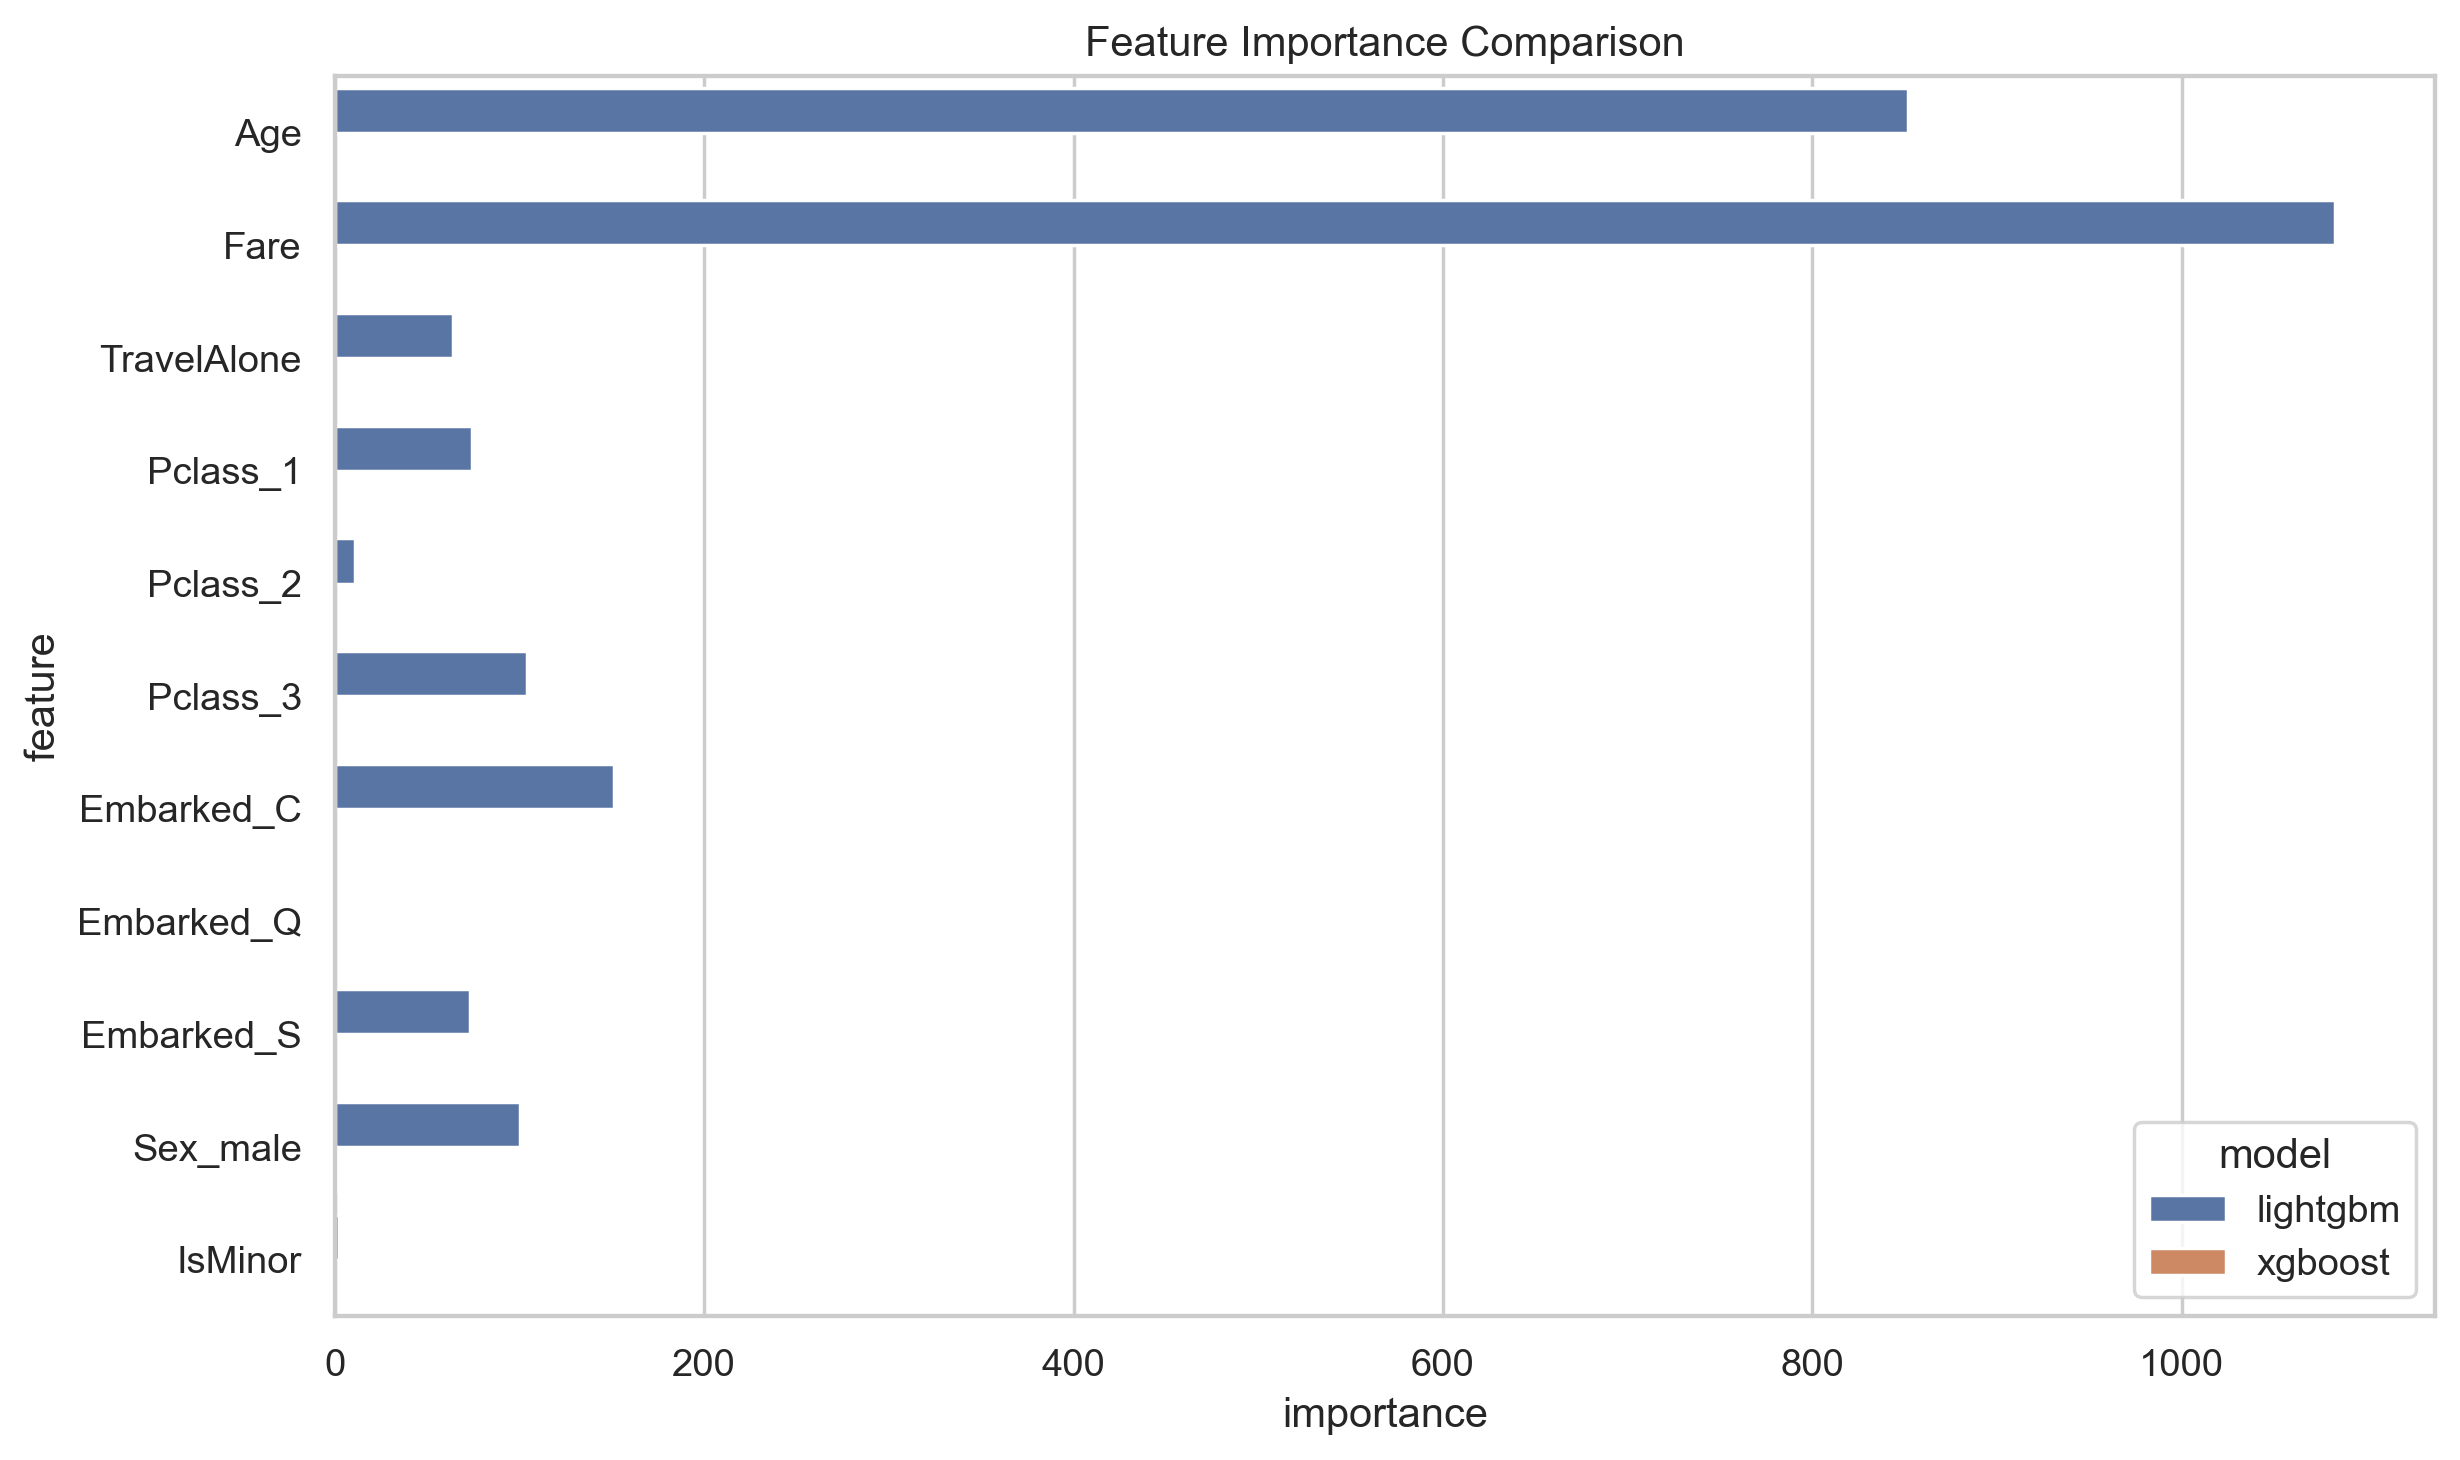

In [32]:
# Feature importance visualization
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'lightgbm': lgbm_best.feature_importances_,
    'xgboost': xgb_best.feature_importances_
})
feature_importance = feature_importance.melt(id_vars=['feature'], var_name='model', value_name='importance')
sns.barplot(x='importance', y='feature', hue='model', data=feature_importance)
plt.title('Feature Importance Comparison')
plt.tight_layout()
plt.show()